In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

## LCG and Poisson Generation


In [2]:
class LCG:
    def __init__(self):
        self.seed = 1234567890
        self.state = self.seed
        self.a = 25214903917
        self.c = 11
        self.m = 1 << 48

    def rand(self):
        self.state = (self.a * self.state + self.c) % self.m
        return self.state / self.m

rng = LCG()
e = 2.718281828459045

def poisson_var(lambda_param, rng):
    limit = e**(-lambda_param)
    p = rng.rand()
    n = 0
    while p > limit:
        p *= rng.rand()
        n += 1
    return n


## Daily Simulation Function


In [3]:
def simulate_day(rng):
    """Generate hourly customer arrivals for a nonstationary Poisson process."""
    arrival_rates = {
        (10, 12): 19,
        (12, 14): 25,
        (14, 16): 27,
        (16, 20): 42,
        (20, 22): 25
    }
    
    results = []
    for hour in range(24):
        if 10 <= hour < 12:
            rate = arrival_rates[(10, 12)]
        elif 12 <= hour < 14:
            rate = arrival_rates[(12, 14)]
        elif 14 <= hour < 16:
            rate = arrival_rates[(14, 16)]
        elif 16 <= hour < 20:
            rate = arrival_rates[(16, 20)]
        elif 20 <= hour < 22:
            rate = arrival_rates[(20, 22)]
        else:
            rate = 0
        
        arrivals = poisson_var(rate, rng)
        results.append((hour, arrivals))
    
    return results


## 4-Day Simulation and Visualization


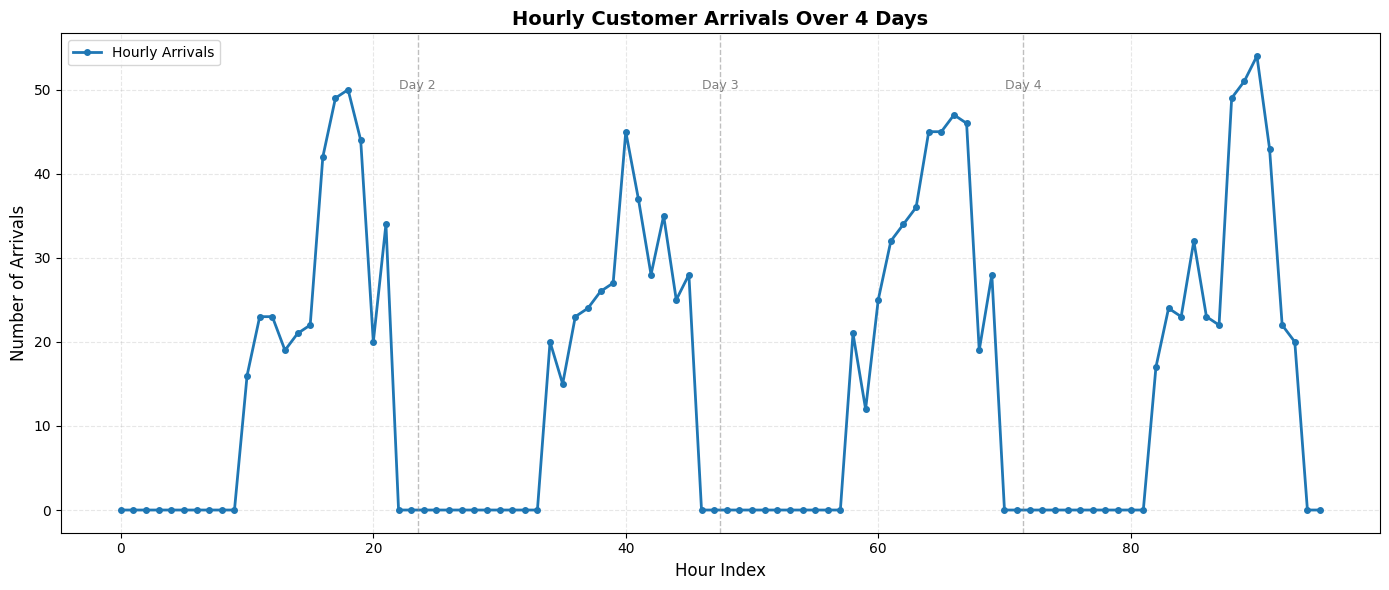

In [4]:
num_days = 4
results = [simulate_day(rng) for _ in range(num_days)]

all_hours = []
all_arrivals = []

hour_index = 0
for day_idx, day_results in enumerate(results):
    for hour, arrivals in day_results:
        all_hours.append(hour_index)
        all_arrivals.append(arrivals)
        hour_index += 1

plt.figure(figsize=(14, 6))
plt.plot(all_hours, all_arrivals, marker='o', linestyle='-', 
         markersize=4, linewidth=2, color='#1f77b4', label='Hourly Arrivals')

hours_per_day = 24
max_arrivals = max(all_arrivals) if all_arrivals else 0
for day in range(1, num_days):
    x_position = day * hours_per_day - 0.5
    plt.axvline(x=x_position, color='gray', linestyle='--', 
                linewidth=1, alpha=0.5)
    plt.text(x_position, max_arrivals * 0.95, f'Day {day + 1}', 
             ha='center', va='top', fontsize=9, color='gray')

plt.xlabel('Hour Index', fontsize=12)
plt.ylabel('Number of Arrivals', fontsize=12)
plt.title(f'Hourly Customer Arrivals Over {num_days} Days', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


## 10-Day Analysis (2-4 PM Interval) (Chi Square Test)


In [5]:
intervals = []
num = 0
cum_sum = 0
lamb = 27
while cum_sum < .8:
    cum_sum += e**(-lamb) * (lamb**num) / math.factorial(num)
    if cum_sum > (len(intervals) + 1) * .2:
        intervals.append((num, cum_sum))
    num += 1

for i in range(4):
    print(f"Interval: [{0 if i == 0 else intervals[i-1][0] + 1}, {intervals[i][0]}], Probability: {intervals[i][1] - (0 if i == 0 else intervals[i-1][1])}, Expected value (p*n): {(intervals[i][1] - (0 if i == 0 else intervals[i-1][1])) * 20}" )
print(f"Interval: [{intervals[-1][0] + 1}, inf), Probability: {1 - intervals[-1][1]}, Expected value: {(1 - intervals[-1][1]) * 20}" )


Interval: [0, 23], Probability: 0.25591260154408996, Expected value (p*n): 5.118252030881799
Interval: [24, 26], Probability: 0.2184904111067431, Expected value (p*n): 4.369808222134862
Interval: [27, 28], Probability: 0.1503462111849534, Expected value (p*n): 3.006924223699068
Interval: [29, 31], Probability: 0.1844254965670694, Expected value (p*n): 3.6885099313413883
Interval: [32, inf), Probability: 0.19082527959714413, Expected value: 3.8165055919428825


In [6]:
num_days = 10
results = [simulate_day(rng) for _ in range(num_days)]

values_2_4_pm = []
for day_results in results:
    for hour, arrivals in day_results:
        if 14 <= hour < 16:
            values_2_4_pm.append(arrivals)

values_2_4_pm.sort()

observed = [0 for _ in range(5)]
for val in values_2_4_pm:
    for i in range(4):
        if val <= intervals[i][0]:
            observed[i] += 1
            break
    else:
        observed[4] += 1

expected = []
expected.append((intervals[0][1]) * 20)
expected.append((intervals[1][1] - intervals[0][1]) * 20)
expected.append((intervals[2][1] - intervals[1][1]) * 20)
expected.append((intervals[3][1] - intervals[2][1]) * 20)
expected.append((1 - intervals[3][1]) * 20)


chi_square = 0
for i in range(5):
    chi_square += (observed[i] - expected[i])**2 / expected[i]

print(observed)
print(chi_square)




[4, 6, 6, 2, 2]
5.46930985602679


## Normal Distribution Generation using Box-Muller Method


In [7]:
def box_muller_normal(rng, mean=16, std=5):
    """Generate normal distribution using Box-Muller method."""
    U1 = rng.rand()
    U2 = rng.rand()
    
    while U1 == 0:
        U1 = rng.rand()
    
    Z0 = math.sqrt(-2 * math.log(U1)) * math.cos(2 * math.pi * U2)
    Z1 = math.sqrt(-2 * math.log(U1)) * math.sin(2 * math.pi * U2)
    
    X0 = mean + std * Z0
    X1 = mean + std * Z1
    
    return X0, X1

n_samples = 150
normal_variables = []

for i in range(n_samples // 2):
    X0, X1 = box_muller_normal(rng, mean=16, std=5)
    normal_variables.append(X0)
    normal_variables.append(X1)

sample_mean = sum(normal_variables) / len(normal_variables)
sample_variance = sum((x - sample_mean) ** 2 for x in normal_variables) / len(normal_variables)
sample_std = math.sqrt(sample_variance)

print(f"Generated variables: {len(normal_variables)}")
print(f"\nExpected values:")
print(f"  Mean (μ): 16.0")
print(f"  Variance (σ²): 25.0 (std=5)")
print(f"\nSample statistics:")
print(f"  Sample Mean: {sample_mean:.4f}")
print(f"  Sample Variance: {sample_variance:.4f}")
print(f"  Sample Std Dev: {sample_std:.4f}")
print(f"\nFirst 10 values: {[f'{x:.4f}' for x in normal_variables[:10]]}")


Generated variables: 150

Expected values:
  Mean (μ): 16.0
  Variance (σ²): 25.0 (std=5)

Sample statistics:
  Sample Mean: 15.9271
  Sample Variance: 21.1562
  Sample Std Dev: 4.5996

First 10 values: ['8.1565', '22.2446', '11.9538', '8.5405', '13.5138', '15.3269', '19.8907', '21.0917', '7.2734', '13.0496']


## Normal Distribution Generation using Binomial Method

In [8]:
def binomial_normal(rng, n=2000, p=0.5, mean=16, std=5):
    """Generate normal distribution using binomial approximation (CLT)."""
    successes = 0
    for _ in range(n):
        if rng.rand() < p:
            successes += 1
    
    binomial_mean = n * p
    binomial_std = math.sqrt(n * p * (1 - p))
    Z = (successes - binomial_mean) / binomial_std
    X = mean + std * Z
    
    return X

n_samples = 150
normal_variables_binomial = []

for i in range(n_samples):
    X = binomial_normal(rng)
    normal_variables_binomial.append(X)

sample_mean_binomial = sum(normal_variables_binomial) / len(normal_variables_binomial)
sample_variance_binomial = sum((x - sample_mean_binomial) ** 2 for x in normal_variables_binomial) / len(normal_variables_binomial)
sample_std_binomial = math.sqrt(sample_variance_binomial)

print(f"Generated variables: {len(normal_variables_binomial)}")
print(f"Binomial parameters: n={2000}, p={0.5}")
print(f"\nExpected values:")
print(f"  Mean (μ): 16.0")
print(f"  Variance (σ²): 25.0 (std=5)")
print(f"\nSample statistics:")
print(f"  Sample Mean: {sample_mean_binomial:.4f}")
print(f"  Sample Variance: {sample_variance_binomial:.4f}")
print(f"  Sample Std Dev: {sample_std_binomial:.4f}")
print(f"\nFirst 10 values: {[f'{x:.4f}' for x in normal_variables_binomial[:10]]}")


Generated variables: 150
Binomial parameters: n=2000, p=0.5

Expected values:
  Mean (μ): 16.0
  Variance (σ²): 25.0 (std=5)

Sample statistics:
  Sample Mean: 15.9434
  Sample Variance: 27.0281
  Sample Std Dev: 5.1989

First 10 values: ['17.7889', '18.2361', '3.9252', '26.5095', '12.4223', '11.9751', '19.1305', '17.3416', '15.5528', '20.2485']


## Q-Q Plot: Box-Muller vs Binomial Methods Comparison


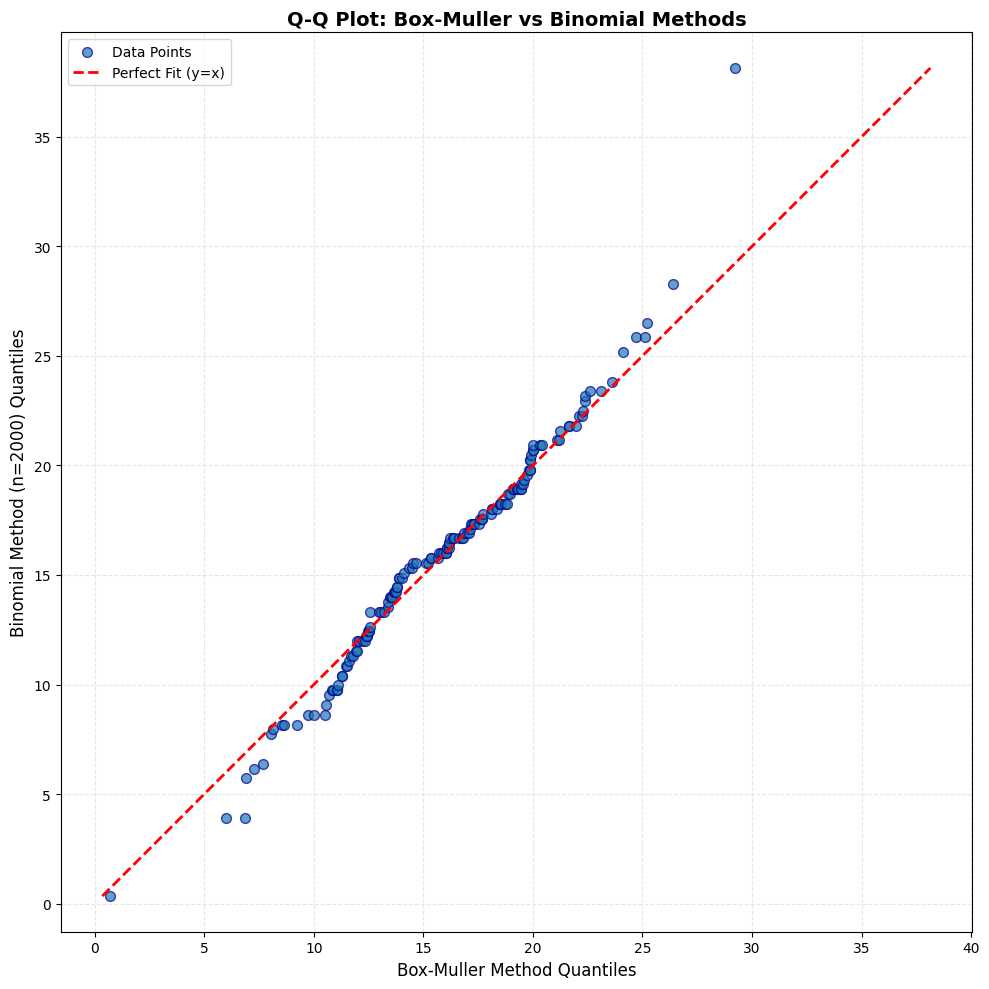

In [9]:
import numpy as np
def qq_plot(data1, data2, labels=['Method 1', 'Method 2'], title='Q-Q Plot'):
    """Plot Q-Q plot comparing two datasets."""
    data1_sorted = np.sort(np.array(data1))
    data2_sorted = np.sort(np.array(data2))
    
    n = min(len(data1_sorted), len(data2_sorted))
    quantiles = np.linspace(0, 1, n)
    
    q1 = np.quantile(data1_sorted, quantiles)
    q2 = np.quantile(data2_sorted, quantiles)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(q1, q2, s=50, alpha=0.7, color='#1f77b4', 
                edgecolors='darkblue', linewidths=1, label='Data Points')
    
    min_val = min(np.min(q1), np.min(q2))
    max_val = max(np.max(q1), np.max(q2))
    plt.plot([min_val, max_val], [min_val, max_val], 
             'r--', linewidth=2, label='Perfect Fit (y=x)')
    
    plt.xlabel(f'{labels[0]} Quantiles', fontsize=12)
    plt.ylabel(f'{labels[1]} Quantiles', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=10)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

qq_plot(
    normal_variables,
    normal_variables_binomial,
    labels=['Box-Muller Method', 'Binomial Method (n=2000)'],
    title='Q-Q Plot: Box-Muller vs Binomial Methods'
)
